In [1]:
!git config user.email "naazshafeer@gmail.com"
!git config user.name "Naaz Shafeer"

In [12]:
pip install astropy

Note: you may need to restart the kernel to use updated packages.


Modelling 2-Body Problem 

In [444]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import scipy as sci
from scipy import integrate
from scipy.integrate import odeint
from matplotlib.patches import Ellipse
from astropy import units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [473]:
print(u.g.find_equivalent_units())

#Define universal gravitation constant
G=6.67408e-11 #N-m2/kg2
#Define masses
m1=1e8 * 1.989e30 #mass of black hole A 
m2=1e8 * 1.989e30 #mass of black hole B
# Will be adding the Standard Gravitational Parameter
mu = G * (m1+m2)
#Define initial position vectors
r1=[ 0.5e14,0,0] #m
r2=[ -0.5e14,0,0] #m (convert these into actual meters instead of the reference used in last code block)
#Convert pos vectors to arrays
r1=np.array(r1,dtype="float64")
r2=np.array(r2,dtype="float64")
#Find Centre of Mass
r_com=(m1*r1+m2*r2)/(m1+m2)
#Define initial velocities
v1=[0,1e6, 0] #m/s
v2=[0,-1e6,0] #m/s
#Convert velocity vectors to arrays
v1=np.array(v1,dtype="float64")
v2=np.array(v2,dtype="float64")
#Find velocity of COM
v_com=(m1*v1+m2*v2)/(m1+m2)

T = 1e8 # we can extract a from here - whole time in seconds
N = 9000
delta_t = T/ N

  Primary name | Unit definition | Aliases                         
[
  M_e          | 9.10938e-31 kg  |                                  ,
  M_p          | 1.67262e-27 kg  |                                  ,
  earthMass    | 5.97217e+24 kg  | M_earth, Mearth                  ,
  g            | 0.001 kg        | gram                             ,
  jupiterMass  | 1.89812e+27 kg  | M_jup, Mjup, M_jupiter, Mjupiter ,
  kg           | irreducible     | kilogram                         ,
  solMass      | 1.98841e+30 kg  | M_sun, Msun                      ,
  t            | 1000 kg         | tonne                            ,
  u            | 1.66054e-27 kg  | Da, Dalton                       ,
]


In [446]:
#WIP Dynamical Friction
rho = 1e9 #just a filler number becuase I do not know the number 
#According to the article, 
f_DF = ((-4*np.pi * G**2 * (m1+m2)**2 * rho)/(v1**3)*f(v_m/c_s)*v_m)

#the f(vm/cs) portion is an equation (has parameters of its own) - specified in the article and that is based on bounded/unbounded (i think)

#But there is also another version(?) in the Galactic Dynamics textbook that has a more simplified version
A = couloumb force
f_DF1 = 0.428 * ln(A) * G*(m1+m2)**2/r**2

#Since we got the percent change to be low in teh energy to be low, we can implement the dynamical friction(?)
# Probably add this in the velocity component like a free-body diagram with the force of friction, check with Mya on accuracy of equations.

#Tangential dynamical friction (vectors), might be easy to implement since we already have got array type velocities, positions, etc (?)


SyntaxError: invalid syntax (3823244072.py, line 9)

In [474]:
def verify_CFL_condition(r1, r2, v1, v2, delta_t, G, m1, m2):
    max_speed = max(np.linalg.norm(v1), np.linalg.norm(v2))
    min_distance = np.linalg.norm(r2 - r1)
    cfl = max_speed * delta_t / min_distance
    print(f"CFL Value: {cfl}")
    return cfl <= 1

cfl_check = verify_CFL_condition(r1, r2, v1, v2, delta_t, G, m1, m2)
print(f"CFL  Satisfied: {cfl_check}")

CFL Value: 0.0001111111111111111
CFL  Satisfied: True


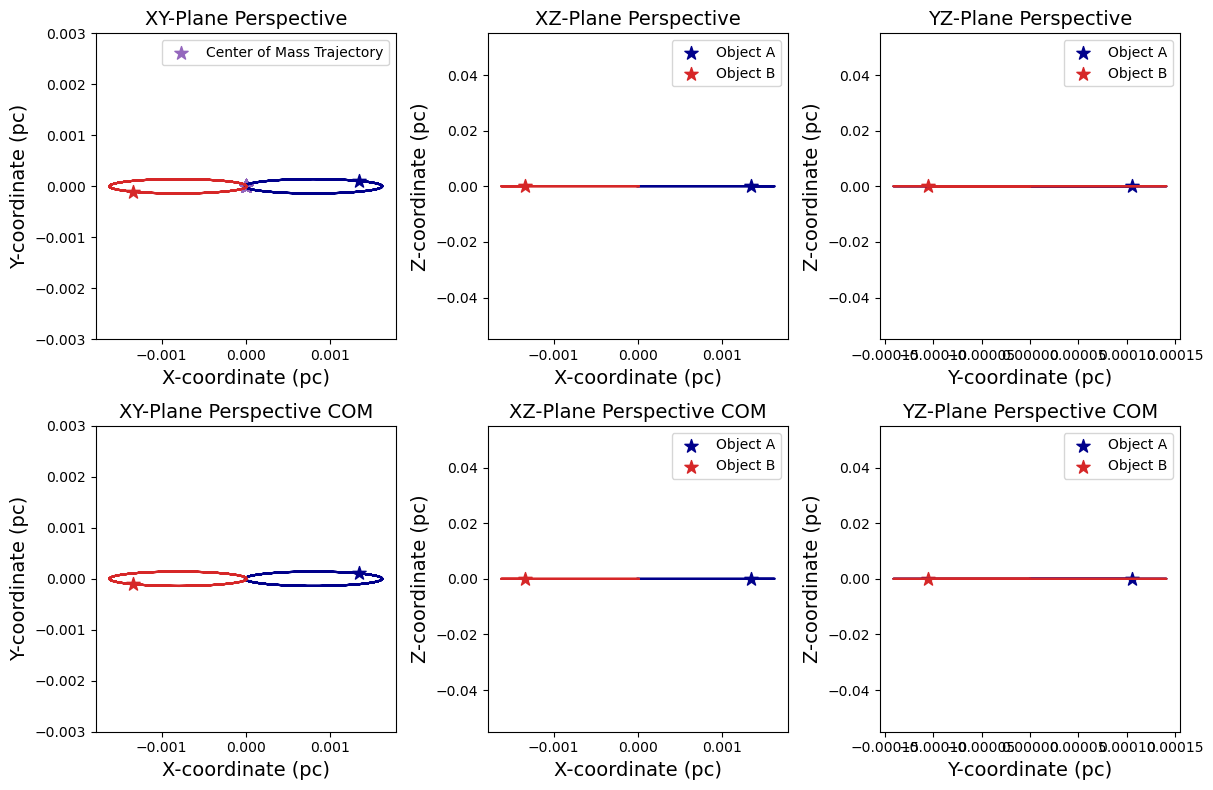

In [475]:
#A function defining the equations of motion 
def TwoBodyEquations(w,t,G,m1,m2):
    r1=w[:3]
    r2=w[3:6]
    v1=w[6:9]
    v2=w[9:12]
    r=np.linalg.norm(r2-r1) #Calculate magnitude or norm of vector
    dv1bydt=G*m2*(r2-r1)/r**3
    dv2bydt=G*m1*(r1-r2)/r**3
    dr1bydt=v1
    dr2bydt=v2
    r_derivs=np.concatenate((dr1bydt,dr2bydt))
    derivs=np.concatenate((r_derivs,dv1bydt,dv2bydt))
    return derivs
# check what w and t is in the code
#Package initial parameters
init_params=np.array([r1,r2,v1,v2]) #create array of initial params
init_params=init_params.flatten() #flatten array to make it 1D
time_span=np.linspace(0, T, N) #Work on this with Kris' link



two_body_sol=sci.integrate.odeint(TwoBodyEquations,init_params,time_span,args=(G,m1,m2)) #make sure to understand what is within this variable

r1_sol = u.m.to(u.pc, two_body_sol[:, :3])
r2_sol = u.m.to(u.pc, two_body_sol[:, 3:6])

#Find location of COM
rcom_sol=(m1*r1_sol+m2*r2_sol)/(m1+m2)

r1com_sol=r1_sol-rcom_sol

r2com_sol=r2_sol-rcom_sol  
#Create figure
fig, axs = plt.subplots(2, 3, figsize=(12, 8)) #looked at article to see how I can line up three differnt persepctives in a row

# region Code Snippet 1: Plot the orbits for XY plane (0,1) in indices
axs[0,0].plot(r1_sol[:,0],r1_sol[:,1],color="darkblue")
axs[0,0].plot(r2_sol[:,0],r2_sol[:,1],color="tab:red")
axs[0,0].scatter(rcom_sol[:, 0], rcom_sol[:, 1], color="tab:purple", marker = "*", s = 100, label="Center of Mass Trajectory")
axs[0,0].set_ylim([-0.003, 0.003])
axs[0,0].scatter(r1_sol[-1,0],r1_sol[-1,1],color="darkblue",marker="*",s=100)
axs[0,0].scatter(r2_sol[-1,0],r2_sol[-1,1],color="tab:red",marker="*",s=100)
axs[0,0].set_xlabel("X-coordinate (pc)",fontsize=14)
axs[0,0].set_ylabel("Y-coordinate (pc)",fontsize=14)
axs[0,0].set_title("XY-Plane Perspective",fontsize=14)
axs[0, 0].legend()


# endregion

# region Code Snippet 2: Plot the orbits for XZ plane (0,2) in indices
axs[0,1].plot(r1_sol[:,0],r1_sol[:,2],color="darkblue")
axs[0,1].plot(r2_sol[:,0],r2_sol[:,2],color="tab:red")
axs[0,1].scatter(r1_sol[-1,0],r1_sol[-1,2],color="darkblue",marker="*",s=100,label="Object A")
axs[0,1].scatter(r2_sol[-1,0],r2_sol[-1,2],color="tab:red",marker="*",s=100,label="Object B")
axs[0,1].set_xlabel("X-coordinate (pc)",fontsize=14)
axs[0,1].set_ylabel("Z-coordinate (pc)",fontsize=14)
axs[0,1].set_title("XZ-Plane Perspective",fontsize=14)
axs[0,1].legend()
# endregion

# region Code Snippet 3: Plot the orbits for YZ plane (1,2) in indices
axs[0,2].plot(r1_sol[:,1],r1_sol[:,2],color="darkblue")
axs[0,2].plot(r2_sol[:,1],r2_sol[:,2],color="tab:red")
axs[0,2].scatter(r1_sol[-1,1],r1_sol[-1,2],color="darkblue",marker="*",s=100,label="Object A")
axs[0,2].scatter(r2_sol[-1,1],r2_sol[-1,2],color="tab:red",marker="*",s=100,label="Object B")
axs[0,2].set_xlabel("Y-coordinate (pc)",fontsize=14)
axs[0,2].set_ylabel("Z-coordinate (pc)",fontsize=14)
axs[0,2].set_title("YZ-Plane Perspective",fontsize=14)
axs[0,2].legend()
# endregion

# region Code Snippet 4: Plot the orbits for XY plane (0,1) in indices but COM
axs[1,0].plot(r1com_sol[:,0],r1com_sol[:,1],color="darkblue")
axs[1,0].plot(r2com_sol[:,0],r2com_sol[:,1],color="tab:red")
axs[1,0].set_ylim([-0.003, 0.003])
axs[1,0].scatter(r1com_sol[-1,0],r1com_sol[-1,1],color="darkblue",marker="*",s=100,label="Object A")
axs[1,0].scatter(r2com_sol[-1,0],r2com_sol[-1,1],color="tab:red",marker="*",s=100,label="Object B")
axs[1,0].set_xlabel("X-coordinate (pc)",fontsize=14)
axs[1,0].set_ylabel("Y-coordinate (pc)",fontsize=14)
axs[1,0].set_title("XY-Plane Perspective COM",fontsize=14)

# endregion

# region Code Snippet 5: Plot the orbits for XZ plane (0,2) in indices but COM
axs[1,1].plot(r1com_sol[:,0],r1com_sol[:,2],color="darkblue")
axs[1,1].plot(r2com_sol[:,0],r2com_sol[:,2],color="tab:red")
axs[1,1].scatter(r1com_sol[-1,0],r1com_sol[-1,2],color="darkblue",marker="*",s=100,label="Object A")
axs[1,1].scatter(r2com_sol[-1,0],r2com_sol[-1,2],color="tab:red",marker="*",s=100,label="Object B")
axs[1,1].set_xlabel("X-coordinate (pc)",fontsize=14)
axs[1,1].set_ylabel("Z-coordinate (pc)",fontsize=14)
axs[1,1].set_title("XZ-Plane Perspective COM",fontsize=14)
axs[1,1].legend()
# endregion

# region Code Snippet 6: Plot the orbits for YZ plane (1,2) in indices but COM
axs[1,2].plot(r1com_sol[:,1],r1com_sol[:,2],color="darkblue")
axs[1,2].plot(r2com_sol[:,1],r2com_sol[:,2],color="tab:red")
axs[1,2].scatter(r1com_sol[-1,1],r1com_sol[-1,2],color="darkblue",marker="*",s=100,label="Object A")
axs[1,2].scatter(r2com_sol[-1,1],r2com_sol[-1,2],color="tab:red",marker="*",s=100,label="Object B")
axs[1,2].set_xlabel("Y-coordinate (pc)",fontsize=14)
axs[1,2].set_ylabel("Z-coordinate (pc)",fontsize=14)
axs[1,2].set_title("YZ-Plane Perspective COM",fontsize=14)
axs[1,2].legend()
# endregion

plt.tight_layout() 
plt.show()



In [449]:
print(rcom_sol)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 ...
 [-4.98961705e-17  1.80270783e-17  0.00000000e+00]
 [-4.98961705e-17  1.80154854e-17  0.00000000e+00]
 [-4.98034267e-17  1.80270783e-17  0.00000000e+00]]


In [485]:
# region Code Snippet 1: Eccentricity for Black Hole B


distances2 = np.linalg.norm(u.pc.to(u.m, r2com_sol), axis = 1)


p_distance2 = np.min(distances2)
a_distance2 = np.max(distances2)


r_p2 = p_distance2
r_a2 = a_distance2 #now we can input the equation for eccentricity

eccentricity2 = (r_a2 - r_p2) / (r_a2 +r_p2)
# endregion

# region Code Snippet 1: Eccentricity for Black Hole A

distances1 = np.linalg.norm(u.pc.to(u.m, r1com_sol - rcom_sol), axis = 1)

# distances1 = np.sqrt(np.sum(np.square(u.pc.to(u.m, r1com_sol)), axis=1))

p_distance1 = np.min(distances1)
a_distance1 = np.max(distances1)

r_p1 = p_distance1
r_a1 = a_distance1

eccentricity1 = (r_a1 - r_p1) / (r_a1 +r_p1)
# endregion


a1 = u.m.to(u.pc, (r_a1 + r_p1) / 2) # Semi Major Axis for Black Hole A
a2 = u.m.to(u.pc, (r_a2 + r_p2) / 2) # Semi Major Axis for Black Hole A

#c = ae so a = c/e and c = (ra-rp)/2/e

a3 = u.m.to(u.pc, (r_a1 - r_p1)  / 2 / eccentricity1)
a4 = u.m.to(u.pc, (r_a2 - r_p2) / 2 / eccentricity2) #this is using another equation to find the semi-major axis


r_p3 = a1*(1-eccentricity1)

#function for semi-minor axis:
b1 = a1 * np.sqrt(1 - eccentricity1**2)
b2 = a2 * np.sqrt(1 - eccentricity2**2)

#orbital periods of the bh's
T1 = 2 * np.pi * np.sqrt((u.pc.to(u.m, b1)**3) / mu)
T2 = 2 * np.pi * np.sqrt((u.pc.to(u.m, b2)**3) / mu)


print(f"Eccentricity of the A orbit: {round(eccentricity1, 3)}") #WOOOOOOOH IT IS  0 < EPSILON < 1 !!!!
print(f"Eccentricity of the B orbit: {round(eccentricity2, 3)}") 
print(f"Semi-Major Axis of the orbit A: {round(a1, 6)} parsecs")
print(f"Semi-Major Axis of the orbit B: {round(a2, 6)} parsecs")
print(f"Semi-Major Axis of the orbit A pt 2: {round(a3, 6)} parsecs")
print(f"Semi-Major Axis of the orbit B pt 2: {round(a4, 6)} parsecs")
print(f"Semi-Minor Axis of the orbit A: {round(b1, 6)} parsecs")
print(f"Semi-Minor Axis of the orbit B: {round(b2, 6)} parsecs")
print(f"Theoretical Orbital Period of BH A: {round(u.s.to(u.year,T1), 6)} years")
print(f"Theoretical Orbital Period of BH B: {round(u.s.to(u.year,T2), 6)} years")



Eccentricity of the A orbit: 0.985
Eccentricity of the B orbit: 0.985
Semi-Major Axis of the orbit A: 0.000816 parsecs
Semi-Major Axis of the orbit B: 0.000816 parsecs
Semi-Major Axis of the orbit A pt 2: 0.000816 parsecs
Semi-Major Axis of the orbit B pt 2: 0.000816 parsecs
Semi-Minor Axis of the orbit A: 0.000141 parsecs
Semi-Minor Axis of the orbit B: 0.000141 parsecs
Theoretical Orbital Period of BH A: 0.01111 years
Theoretical Orbital Period of BH B: 0.01111 years


In [477]:
print(r2com_sol)

[[-1.62038964e-03  0.00000000e+00  0.00000000e+00]
 [-1.62038698e-03 -3.60126403e-07  0.00000000e+00]
 [-1.62037901e-03 -7.20251626e-07  0.00000000e+00]
 ...
 [-1.34946862e-03 -1.05055874e-04  0.00000000e+00]
 [-1.34760964e-03 -1.05343573e-04  0.00000000e+00]
 [-1.34574304e-03 -1.05630676e-04  0.00000000e+00]]


In [478]:
print(u.m.to(u.pc,distances2))

[0.00162039 0.00162039 0.00162038 ... 0.00135355 0.00135172 0.00134988]


In [479]:
# Calculate specific angular momentum
r = r2com_sol[:, :2]  # Position vector in the XY plane
v = np.gradient(r2com_sol[:, :2], axis=0)  # Velocity vector, approximated by gradient
h = np.cross(r, v)[-1]  # Specific angular momentum

# Calculate distance at perihelion (closest approach)
r_min = np.min(np.linalg.norm(r, axis=1))

# Calculate semi-major axis
a = r_min / (1 - eccentricity2)

# Calculate eccentricity
eccentricity2 = 1 - (h**2 / (G * (m1 + m2) * a))

# Print or use eccentricity2 as needed
print(f"Eccentricity of Black Hole B: {eccentricity2:.4f}")

Eccentricity of Black Hole B: 1.0000


In [480]:
a = r_p1 / (1 - eccentricity1)
print(u.m.to(u.pc, a))
T1 = np.sqrt((4*(np.pi)**2 / mu) * b1**3)
print(T1)

0.0008163905261652667
6.468233955423827e-20


Simulated Orbital Period: 2.40e+00 year(s)
[13790421.15790644]
[0.43699208]


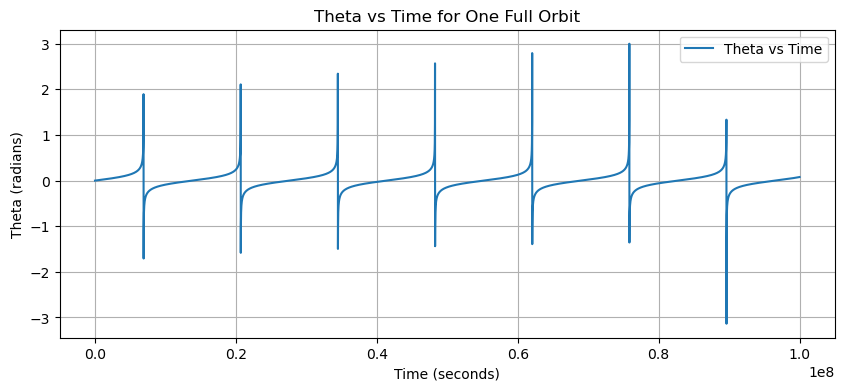

6.468233955423827e-20


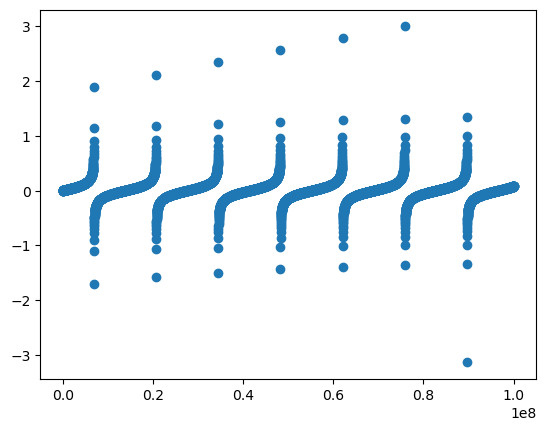

In [481]:
#Check if simulated and observed are matching

# c1y = (np.max(r1_sol[:,1]) + np.min(r1_sol[:,1])) / 2
# c1x = (np.max(r1_sol[:,0]) + np.min(r1_sol[:,0])) / 2
# c1 = np.mean(r1_sol, axis=0)

# c1x = rcom_sol[:,0]
# c1y = rcom_sol[:,1]
# c = np.array([c1x, c1y, 0])


angles = np.arctan2(u.pc.to(u.m, r1_sol[:, 1]) -  u.pc.to(u.m, rcom_sol[:,1]), u.pc.to(u.m, r1_sol[:, 0]) - u.pc.to(u.m, rcom_sol[:,0]))  # arctan2 gives the angle in radians


#- u.pc.to(u.m, c1[1])

# angles = np.mod(angles, 2 * np.pi)

# start_idx = np.where(np.diff(np.unwrap(angles)) < 0)[0] + 1  # Where angle decreases (start of new orbit)
# end_idx = start_idx  # End of first orbit is start of second orbit

# # Calculate simulated orbital periods
# orbit_periods = time_span[end_idx] - time_span[start_idx]

orbital_period = None
for i in range(1, len(angles)):
    if angles[i] == np.max(angles):
        orbital_period = time_span[i] - time_span[0]
        break

# Check if orbital_period was found
if orbital_period is not None:
    orbital_period_years = u.s.to(u.year, orbital_period)
    print(f"Simulated Orbital Period: {round(orbital_period_years, 3):.2e} year(s)")
else:
    print("No complete orbit found within the given data.")


# initial_angle = np.max(angles)
# orbital_period = None
# for i in range(1, len(angles)):
#     if np.isclose(angles[i], initial_angle, atol=1e-6):
#         orbital_period = time_span[i] - time_span[0]
#         break
# if orbital_period is not None:
#     orbital_period_years = u.s.to(u.year, orbital_period)
#     print(f"Simulated Orbital Period: {orbital_period_years:.2e} year(s)")
# else:
#     print("No complete orbit found within the given data.")

start = np.where(angles == np.max(angles))
end = np.where(angles == np.min(angles))

time = time_span[end] - time_span[start]
print(time)
print(u.s.to(u.year, time))

plt.figure(figsize=(10, 4))
plt.plot(time_span, angles, label='Theta vs Time')
plt.xlim()
plt.xlabel('Time (seconds)')
plt.ylabel('Theta (radians)')
plt.title('Theta vs Time for One Full Orbit')
plt.grid(True)

plt.legend()
plt.show()


plt.scatter(time_span, angles)

print(T1)



Simulated Orbital Period: 0.4370 years


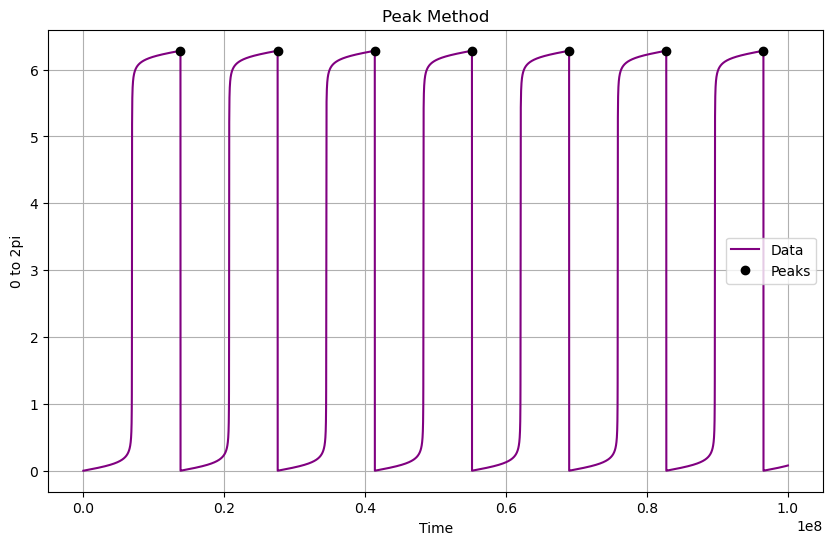

1st Peak Time: 13779308.81 seconds (Index: 1240)
2nd Peak Time: 27569729.97 seconds (Index: 2481)
Simulated Orbital Period: 0.4370 years


In [482]:
from scipy.signal import find_peaks

#COM
# r1com_x = r1_sol_pc[:, 0] - rcom_sol[:, 0]
# r1com_y = r1_sol_pc[:, 1] - rcom_sol[:, 1]
# angles = np.arctan2(r1com_y, r1com_x)

c1y = (np.max(r1_sol[:,1]) + np.min(r1_sol[:,1])) / 2
c1x = (np.max(r1_sol[:,0]) + np.min(r1_sol[:,0])) / 2
c = np.array([u.pc.to(u.m,c1x), u.pc.to(u.m, c1y), 0])


# angles = np.arctan2(u.pc.to(u.m, r1_sol[:, 1]) -  c[1], u.pc.to(u.m, r1_sol[:, 0]) - c[0]) #apparently, using the center of the ellipses and the COM does not have affect on teh orbital period?



angles_norm = angles - angles[0]
angles_norm = np.mod(angles_norm, 2 * np.pi)


peaks, _ = find_peaks(angles_norm)


if len(peaks) >= 2:
    orbital_period = time_span[peaks[1]] - time_span[peaks[0]]
    orbital_period_years = orbital_period * u.s.to(u.year)
    print(f"Simulated Orbital Period: {orbital_period_years:.4f} years")
else:
    print("None")


plt.figure(figsize=(10, 6))
plt.plot(time_span, angles_norm, label='Data', color = 'purple')
plt.plot(time_span[peaks], angles_norm[peaks], 'o', color='black', label='Peaks')
plt.xlim()
plt.xlabel('Time')
plt.ylabel('0 to 2pi')
plt.title('Peak Method')
plt.grid(True)
plt.legend()
plt.show()

if len(peaks) >= 2:
    first_peak_time = time_span[peaks[0]]
    print(f"1st Peak Time: {first_peak_time:.2f} seconds (Index: {peaks[0]})")

    second_peak_time = time_span[peaks[1]]
    print(f"2nd Peak Time: {second_peak_time:.2f} seconds (Index: {peaks[1]})")

    orbital_period = second_peak_time - first_peak_time
    orbital_period_years = orbital_period * u.s.to(u.year)
    print(f"Simulated Orbital Period: {orbital_period_years:.4f} years")
else:
    print("None")

In [494]:
T1 = np.sqrt((4 * np.pi**2 * u.pc.to(u.m, a1)**3) / (G * (m1 + m2)))
T2 = np.sqrt((4 * np.pi**2 * u.pc.to(u.m, a2)**3) / (G * (m1 + m2)))

print(f"Theoretical Orbital Period of BH A: {round(u.s.to(u.year,T1), 6)} years")
print(f"Theoretical Orbital Period of BH B: {round(u.s.to(u.year,T2), 6)} years")
print(f"Simulated Orbital Period of BH A: {orbital_period_years} years")

Theoretical Orbital Period of BH A: 0.154497 years
Theoretical Orbital Period of BH B: 0.154497 years
Simulated Orbital Period of BH A: 0.4369920766441818 years


In [321]:
print(a1,a2,a3,a4,b1,b2)

0.001645190998020877 0.0016451909980208768 0.001645190998020877 0.0016451909980208768 0.0004008771451232762 0.00040087714512327614


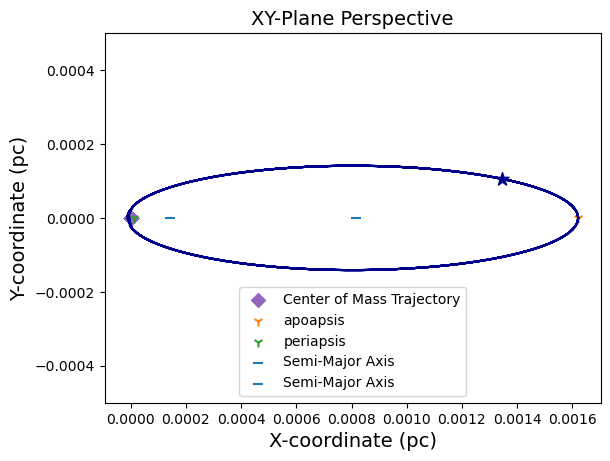

1.2298940068320605e-05 0.0016204821122622088


In [484]:

plt.plot(r1_sol[:,0],r1_sol[:,1],color="darkblue")
# plt.plot(r2_sol[:,0],r2_sol[:,1],color="tab:red")
plt.scatter(rcom_sol[:, 0], rcom_sol[:, 1], color="tab:purple", marker = "D", s = 50, label="Center of Mass Trajectory")
plt.scatter(u.m.to(u.pc, r_a1), 0, color = "tab:orange",marker = "1" ,s = 50, label = "apoapsis")
plt.scatter(u.m.to(u.pc, r_p1), 0, color = "tab:green", marker = "1", s = 50, label = "periapsis")
# plt.scatter(, -b2, -a1, -b2, color = "tab:blue", s = 50)
plt.scatter(a1, 0, color = "tab:blue", s = 50, marker = "_", label = "Semi-Major Axis")
plt.scatter(b1, 0, color = "tab:blue", s = 50, marker = "_", label = "Semi-Major Axis")
plt.ylim([-0.0005, 0.0005])
plt.scatter(r1_sol[-1,0],r1_sol[-1,1],color="darkblue",marker="*",s=100)
# plt.scatter(r2_sol[-1,0],r2_sol[-1,1],color="tab:red",marker="*",s=100)
plt.xlabel("X-coordinate (pc)",fontsize=14)
plt.ylabel("Y-coordinate (pc)",fontsize=14)
plt.title("XY-Plane Perspective",fontsize=14)
plt.legend(loc = "lower center")

plt.show()

print(u.m.to(u.pc,r_p1), u.m.to(u.pc,r_a1))

In [417]:
print("Center of Mass:", r_com)

Center of Mass: [0. 0. 0.]


In [418]:
print("Distances from COM for Black Hole A:", distances1)
print("Distances from COM for Black Hole B:", distances2)

Distances from COM for Black Hole A: [5.00000000e+13 4.99998976e+13 4.99995911e+13 ... 4.17803325e+13
 4.17168201e+13 4.16530150e+13]
Distances from COM for Black Hole B: [5.00000000e+13 4.99998976e+13 4.99995911e+13 ... 4.17803325e+13
 4.17168201e+13 4.16530150e+13]


In [463]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import astropy.units as u

# Constants
G = 6.67408e-11  # N-m2/kg2
mu = G * (m1 + m2)  # Standard gravitational parameter

# Function to compute eccentricity
def compute_eccentricity(r_p, r_a):
    return (r_a - r_p) / (r_a + r_p)

# Function to compute semi-major axis
def compute_semi_major_axis(r_p, r_a):
    return (r_a + r_p) / 2

# Function to compute semi-minor axis
def compute_semi_minor_axis(a, e):
    return a * np.sqrt(1 - e**2)

# Function to compute orbital period
def compute_orbital_period(a, mu):
    return np.sqrt((4 * np.pi**2 / mu) * a**3)

# Theoretical data
# Eccentricity and Semi-Major Axis for Black Hole A
r_p1 = p_distance1
r_a1 = a_distance1
eccentricity1 = compute_eccentricity(r_p1, r_a1)
a1 = compute_semi_major_axis(r_p1, r_a1)

# Eccentricity and Semi-Major Axis for Black Hole B
r_p2 = p_distance2
r_a2 = a_distance2
eccentricity2 = compute_eccentricity(r_p2, r_a2)
a2 = compute_semi_major_axis(r_p2, r_a2)

# Semi Minor Axis for Black Hole A and B
b1 = compute_semi_minor_axis(a1, eccentricity1)
b2 = compute_semi_minor_axis(a2, eccentricity2)

# Orbital periods of the black holes
T1 = compute_orbital_period(a1, mu)
T2 = compute_orbital_period(a2, mu)

# Print the theoretical results
print(f"Eccentricity of the A orbit: {round(eccentricity1, 3)}")
print(f"Eccentricity of the B orbit: {round(eccentricity2, 3)}")
print(f"Semi-Major Axis of the orbit A: {round(a1, 6)} meters")
print(f"Semi-Major Axis of the orbit B: {round(a2, 6)} meters")
print(f"Semi-Minor Axis of the orbit A: {round(b1, 6)} meters")
print(f"Semi-Minor Axis of the orbit B: {round(b2, 6)} meters")
print(f"Theoretical Orbital Period of BH A: {round(u.s.to(u.year, T1), 6)} years")
print(f"Theoretical Orbital Period of BH B: {round(u.s.to(u.year, T2), 6)} years")

# Calculate angles relative to center of mass
r1com_x = r1_sol_pc[:, 0] - rcom_sol[:, 0]
r1com_y = r1_sol_pc[:, 1] - rcom_sol[:, 1]
angles = np.arctan2(r1com_y, r1com_x)

# Normalize angles to start from zero
angles_normalized = angles - angles[0]
angles_normalized = np.mod(angles_normalized, 2 * np.pi)

# Find peaks in the angular position (indicating a return to starting point)
peaks, _ = find_peaks(angles_normalized)

# Check if at least two peaks are found
if len(peaks) >= 2:
    orbital_period = time_span[peaks[1]] - time_span[peaks[0]]
    orbital_period_years = u.s.to(u.year, orbital_period)
    print(f"Simulated Orbital Period of BH A: {orbital_period_years:.4f} years")
else:
    print("Unable to determine orbital period for BH A from the given data.")

Eccentricity of the A orbit: 0.979
Eccentricity of the B orbit: 0.979
Semi-Major Axis of the orbit A: 25263812575587.695 meters
Semi-Major Axis of the orbit B: 25263812575586.96 meters
Semi-Minor Axis of the orbit A: 5122438522497.2295 meters
Semi-Minor Axis of the orbit B: 5122438522496.873 meters
Theoretical Orbital Period of BH A: 0.155166 years
Theoretical Orbital Period of BH B: 0.155166 years
Simulated Orbital Period of BH A: 0.2143 years


(array([   0,    1,    2, ..., 7997, 7998, 7999]),)

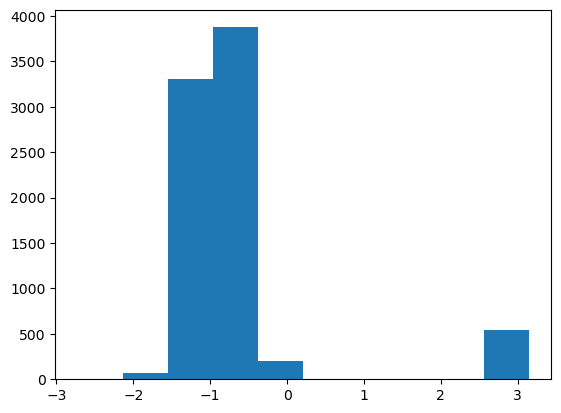

In [464]:

y = np.where((angles - angles[0]) <= 1e-4)[0]
x = np.arange(len(y))
# plt.plot(x,y)
y.shape

plt.hist(angles)
np.where(angles)


The average energy would be -2.6203770656258847e+52 J
The fractional energy would be -1.7685852782278743e-16 J
Using the Fractional Energy method, we get the percent change of -1.7685963804581205e-14 %


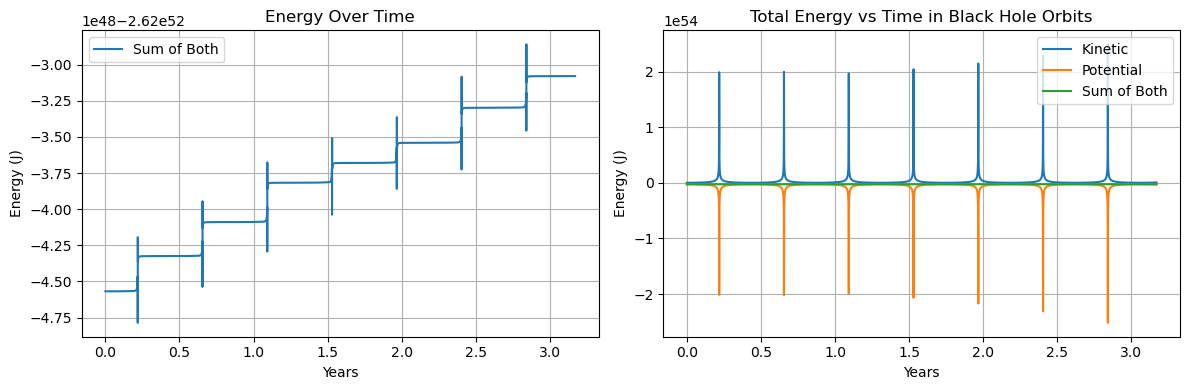

In [465]:
v1_sol = two_body_sol[:, 6:9]
v2_sol = two_body_sol[:, 9:12]

KE = 0.5 * m1 * np.sum(v1_sol**2, axis=1) + 0.5 * m2 * np.sum(v2_sol**2, axis=1)
V = -G * m1 * m2 / np.linalg.norm(u.pc.to(u.m, r2_sol) - u.pc.to(u.m, r1_sol), axis = 1)
E = V + KE

time_span_year = u.s.to(u.year, time_span)
avg_energy = np.mean(E)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# region Code Snippet 6: Energy Graph Plot

axs[0].plot(time_span_year, E, label = "Sum of Both")
axs[0].set_xlabel("Years")
axs[0].set_ylabel("Energy (J)")
axs[0].set_title("Energy Over Time")
axs[0].legend()
axs[0].grid()

# endregion
# region Code Snippet 7: Energy Graph Plot

axs[1].plot(time_span_year, KE, label="Kinetic")
axs[1].plot(time_span_year, V, label = "Potential") 
axs[1].plot(time_span_year, E, label = "Sum of Both")
axs[1].set_xlabel("Years")
axs[1].set_ylabel("Energy (J)")
axs[1].set_title("Total Energy vs Time in Black Hole Orbits")
axs[1].legend()
axs[1].grid()
# endregion

#Fractional Energy work >

frac_energy = (E - avg_energy) / avg_energy
percent = frac_energy * 100

print(f"The average energy would be {round(avg_energy,6)} J")
print(f"The fractional energy would be {np.mean(frac_energy)} J")
print(f"Using the Fractional Energy method, we get the percent change of {np.mean(percent)} %")

plt.tight_layout()
plt.show()


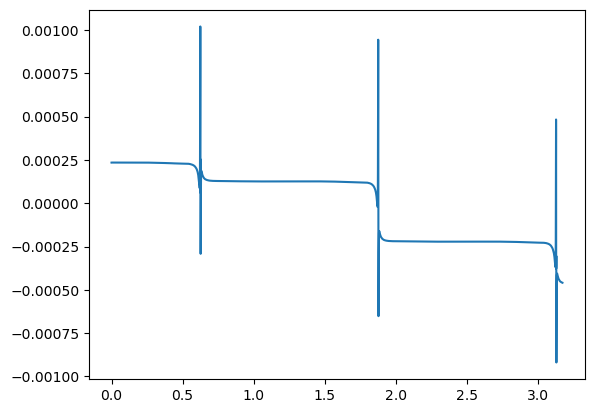

In [227]:
plt.plot(time_span_year, percent)

- review on the part where the switch from com to keplers thrid law (???)
- fit the ellpise equation to the orbit and then extract the semi major axis from teh orbit and plug into this formula and plot like a (did not work as I wanted to)
- chi2
- convert from angle to time correctly (find another way other than keplers law)


In [ ]:
#still working on this

DIM = 2
# Extract x coords and y coords of the ellipse as column vectors
X = r1_sol[:,0]
Y = r1_sol[:,1] #limit it only till second column, 

# Formulate and solve the least squares problem ||Ax - b ||^2
A = np.hstack([X**2, X * Y, Y**2, X, Y])
b = np.ones_like(X)
x = np.linalg.lstsq(A, b)[0].squeeze()

# Print the equation of the ellipse in standard form
print('The ellipse is given by {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(x[0], x[1],x[2],x[3],x[4]))

# Plot the noisy data
plt.scatter(X, Y, label='Data Points')

# Plot the original ellipse from which the data was generated
phi = np.linspace(0, 2*np.pi, 1000).reshape((1000,1))
c = np.hstack([np.cos(phi), np.sin(phi)])
B = B = np.random.randint(-3, 3, (DIM, DIM))
ground_truth_ellipse = c.dot(B)
plt.plot(ground_truth_ellipse[:,0], ground_truth_ellipse[:,1], 'k--', label='Generating Ellipse')

# Plot the least squares ellipse
x_coord = np.linspace(-5,5,300)
y_coord = np.linspace(-5,5,300)
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = x[0] * X_coord ** 2 + x[1] * X_coord * Y_coord + x[2] * Y_coord**2 + x[3] * X_coord + x[4] * Y_coord
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

rcond=None

KeyboardInterrupt: 

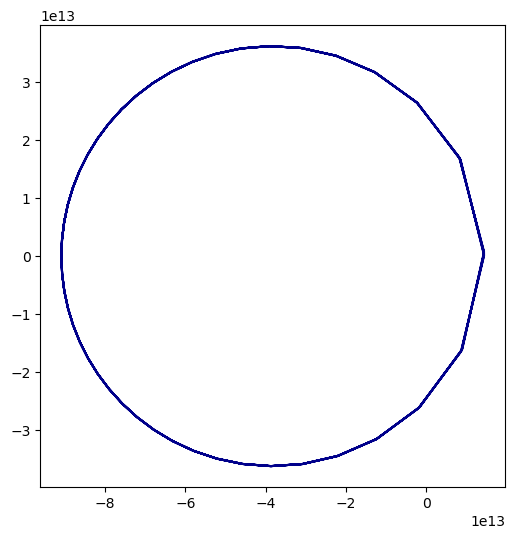

In [59]:
import moviepy
from moviepy.editor import ImageSequenceClip
import os
frames_dir = "frames"
if not os.path.exists(frames_dir):
    os.makedirs(frames_dir)

# Generate frames
for i, (r1, r2) in enumerate(zip(r1com_sol, r2com_sol)):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(r1com_sol[:i+1, 0], r1com_sol[:i+1, 1], color="darkblue")
    ax.plot(r2com_sol[:i+1, 0], r2com_sol[:i+1, 1], color="tab:red")
    ax.scatter(r1[0], r1[1], color="darkblue", marker="*", s=100, label="Object A")
    ax.scatter(r2[0], r2[1], color="tab:red", marker="*", s=100, label="Object B")
    ax.set_xlabel("X-coordinate", fontsize=14)
    ax.set_ylabel("Y-coordinate", fontsize=14)
    ax.set_title("XY-Plane Perspective COM", fontsize=14)
    ax.legend()
    plt.savefig(f"{frames_dir}/frame_{i:04d}.png")
    plt.close()

print("Frames generated.")

In [ ]:
# Create a movie from the frames
frames = [f"{frames_dir}/frame_{i:04d}.png" for i in range(len(r1com_sol))]
clip = ImageSequenceClip(frames, fps=24) # You can adjust fps (frames per second)

# Save the movie
clip.write_videofile("black_hole_orbits.mp4", codec='libx264')


Moviepy - Building video black_hole_orbits.mp4.
Moviepy - Writing video black_hole_orbits.mp4



TypeError: must be real number, not NoneType

NameError: name 'R1_rel_COG' is not defined

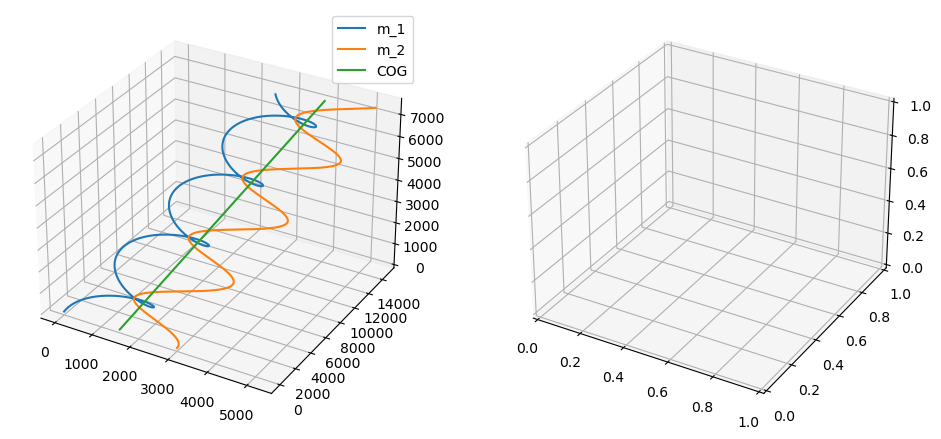

In [ ]:
import numpy as np

G = 6.67430e-20  # km**3/(kg * s**2)
m_1 = m_2 = 1.0e26  # kg

R_1_0 = np.array((0, 0, 0))  # km
R_2_0 = np.array((3000, 0, 0))  # km
dotR_1_0 = np.array((10, 20, 30))  # km/s
dotR_2_0 = np.array((0, 40, 0))  # km/s

y_0 = np.hstack((R_1_0, R_2_0, dotR_1_0, dotR_2_0))

X_1 = y_0[0]
Y_1 = y_0[1]
Z_1 = y_0[2]
X_2 = y_0[3]
Y_2 = y_0[4]
Z_2 = y_0[5]

r = np.sqrt((X_2 - X_1) ** 2 + (Y_2 - Y_1) ** 2 + (Z_2 - Z_1) ** 2)

ddotX_1 = G * m_2 * (X_2 - X_1) / r**3
ddotY_1 = G * m_2 * (Y_2 - Y_1) / r**3
ddotZ_1 = G * m_2 * (Z_2 - Z_1) / r**3
ddotX_2 = -G * m_1 * (X_2 - X_1) / r**3
ddotY_2 = -G * m_1 * (Y_2 - Y_1) / r**3
ddotZ_2 = -G * m_1 * (Z_2 - Z_1) / r**3

R_1 = y_0[:3]
R_2 = y_0[3:6]

r = np.sqrt(np.sum(np.square(R_2 - R_1)))
ddot = G * (R_2 - R_1) / r**3
ddotR_1_0 = m_2 * ddot
ddotR_2_0 = -m_1 * ddot

Delta_t = 1  # s
dotR_1_1 = ddotR_1_0 * Delta_t + dotR_1_0
dotR_2_1 = ddotR_2_0 * Delta_t + dotR_2_0

R_1_1 = dotR_1_0 * Delta_t + R_1_0
R_2_1 = dotR_2_0 * Delta_t + R_2_0

import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


def absolute_motion(t, y):
    """Calculate the motion of a two-body system in an inertial reference frame.

    The state vector ``y`` should be in the order:

    1. Coordinates of $m_1$
    2. Coordinates of $m_2$
    3. Velocity components of $m_1$
    4. Velocity components of $m_2$
    """
    # Get the six coordinates for m_1 and m_2 from the state vector
    R_1 = y[:3]
    R_2 = y[3:6]

    # Fill the derivative vector with zeros
    ydot = np.zeros_like(y)

    # Set the first 6 elements of the derivative equal to the last
    # 6 elements of the state vector, which are the velocities
    ydot[:6] = y[6:]

    # Calculate the acceleration terms and fill them in to the rest
    # of the derivative array
    r = np.sqrt(np.sum(np.square(R_2 - R_1)))
    ddot = G * (R_2 - R_1) / r**3
    ddotR_1 = m_2 * ddot
    ddotR_2 = -m_1 * ddot

    ydot[6:9] = ddotR_1
    ydot[9:] = ddotR_2
    return ydot


t_0 = 0  # seconds
t_f = 480  # seconds
t_points = np.linspace(t_0, t_f, 1000)

sol = solve_ivp(absolute_motion, [t_0, t_f], y_0, t_eval=t_points)

y = sol.y.T
R_1 = y[:, :3]  # km
R_2 = y[:, 3:6]  # km
V_1 = y[:, 6:9]  # km/s
V_2 = y[:, 9:]  # km/s
barycenter = (m_1 * R_1 + m_2 * R_2) / (m_1 + m_2)  # km

fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(131, projection="3d")
ax1.plot(R_1[:, 0], R_1[:, 1], R_1[:, 2], label="m_1")
ax1.plot(R_2[:, 0], R_2[:, 1], R_2[:, 2], label="m_2")
ax1.plot(barycenter[:, 0], barycenter[:, 1], barycenter[:, 2], label="COG")
ax1.legend()

ax2 = fig.add_subplot(132, projection="3d")
ax2.plot(R1_rel_COG[:, 0], R1_rel_COG[:, 1], R1_rel_COG[:, 2], label="m_1")
ax2.plot(R2_rel_COG[:, 0], R2_rel_COG[:, 1], R2_rel_COG[:, 2], label="m_2")
ax2.plot(0, 0, 0, "ro", label="COG")
ax2.legend()

ax3 = fig.add_subplot(133, projection="3d")
ax3.plot(R2_rel_R1[:, 0], R2_rel_R1[:, 1], R2_rel_R1[:, 2], label="m_2")
ax3.plot(COG_rel_R1[:, 0], COG_rel_R1[:, 1], COG_rel_R1[:, 2], label="COG")
ax3.plot(0, 0, 0, "ro", label="m_1")
ax3.legend()

plt.show()


